# What I do here

1. I download all Hikaru's games
2. I calculate how likely it is that Hikaru wins each game based on the Elo difference
3. I simulate all the Hikaru's games this year based on these likelihoods. I run the simulation 10,000x and check the longest win streak in each simulation.

## Result

On average, Hikaru should have achieved a maximum win streak of 47.41 blitz games this year.

# Some caveats

I have made several simplifications:

1. I assume that the expected point gain is linear w.r.t. the Elo difference. Each 100 Elo points give you 9.7% increase in your win percentage. This should be okay according to [this analysis](https://en.chessbase.com/post/the-sonas-rating-formula-better-than-elo).  
2. I do not simulate draws, but this should make the win streaks even harder if anything.

In [ ]:
!pip install chess.com

In [ ]:
from itertools import accumulate, chain

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm
from sklearn.linear_model import LinearRegression

from chessdotcom import Client, get_player_games_by_month

In [ ]:
"""
Get all the data from chess.com API, filter the relevant games, and get the relevant columns
"""

# Possible game outcomes according to chess.com
result_map = {
  'win': 1,
  'resigned': 0,
  'repetition': 0.5,
  'agreed': 0.5,
  'timeout': 0,
  'insufficient': 0.5,
  'checkmated': 0,
  'stalemate': 0.5,
  '50move': 0.5,
  'timevsinsufficient': 0.5,
  'abandoned': 0,
}

Client.request_config['headers']['User-Agent'] = (
  'Hikaru winrate Colab'
)

def get_month_games(month):
  # Get the data from chess.com API
  response = get_player_games_by_month("Hikaru", 2023, month)
  games = response.json['games']

  # Filter only blitz games with standard chess rules when the ELO diff is less than 1000
  games = [
    game
    for game in games
    if game['time_class'] == 'blitz' and game['rules'] == 'chess' and abs(game['white']['rating'] - game['black']['rating']) < 1000
  ]

  # Get only relevant data White ELO, Black ELO, White result, Hikaru color
  games = [
    (game['white']['rating'], game['black']['rating'], result_map[game['white']['result']], game['white']['username'] == 'Hikaru')
    for game in games
  ]

  return games


# Concatenate the data for 2023 months
games = pd.DataFrame(
  chain.from_iterable(get_month_games(month) for month in range(1, 12)),
  columns=['white_elo', 'black_elo', 'white_result', 'hikaru_white'],
)

games

,white_elo,black_elo,white_result,hikaru_white
0,2538,3219,0.0,False
1,3220,2714,1.0,True
2,2839,3206,1.0,False
3,3207,2694,1.0,True
4,2785,3208,0.0,False
...,...,...,...,...
3845,3223,2951,1.0,True
3846,2948,3226,0.0,False
3847,3229,2945,1.0,True
3848,2942,3232,0.0,False


In [ ]:
"""
Calculate estimated white player point gain
"""

lin_reg = LinearRegression().fit([[val] for val in games.white_elo - games.black_elo], games.white_result)
games['white_expected'] = ((games.white_elo - games.black_elo) * lin_reg.coef_) + lin_reg.intercept_

# Predicted point gain for white vs true point gain. Almost perfect fit indicating that the linaer regression is an okay model for this.
sum(games['white_expected']), sum(games['white_result'])

(2025.0000000000007, 2025.0)

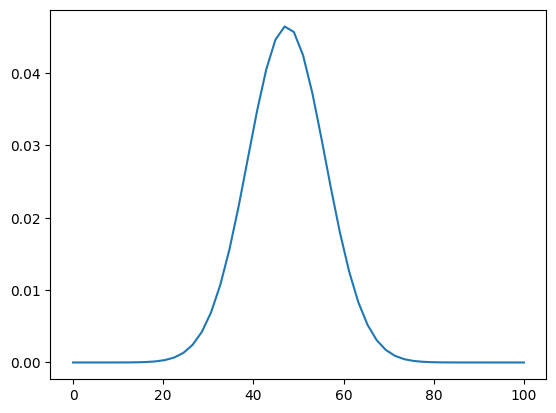

In [ ]:
def simulate(n=10000):
  """
  Return max winstreak size for `n` simulations
  """
  for _ in range(n):
    white_wins = np.random.rand(len(games)) < games.white_expected  # Based on the ELO diffs, simulate all the games
    hikaru_wins = white_wins == games.hikaru_white  # Did Hikaru win?
    yield max(accumulate(hikaru_wins, lambda acc, e: acc * e + e))  # Calculate max winstreak

max_winstreaks = list(simulate())

plt.plot(np.linspace(0, 100), norm.pdf(np.linspace(0, 100), *(norm.fit(max_winstreaks))))

In [ ]:
print(f'The expected max winstreak should be in [{norm.ppf(0.05, *(norm.fit(max_winstreaks))):.2f}, {norm.ppf(0.95, *(norm.fit(max_winstreaks))):.2f}] interval')
print(f'The average expected max winstreak is {norm.ppf(0.5, *(norm.fit(max_winstreaks))):.2f}')

The expected max winstreak should be in [33.25, 61.47] interval
The average expected max winstreak is 47.36
